In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib agg

import visualization
from data import datasets, evaluation
import transformations
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.core import freeze
import optax
import json
import os
import inference
from utils import settings, evaluation
import global_settings
import matplotlib.pyplot as plt

rng_key = jax.random.PRNGKey(0)

dataset_name = "izmailov"
network_size = "small" # "big"

# ugly function definitions

In [2]:
def load_dataset(name):
    if name in global_settings.DATASET_NAMES_TOY:
        with open(os.path.join(global_settings.PATH_DATASETS, "toy_dataset_indices_0.2.json"), 'r') as f:
            indices = json.load(f)
            split = {
                "data_train": indices[name]["train"],
                "data_validate": [],
                "data_test": indices[name]["validate"] # validate as test data, since we do not need validation data...
            }
    elif name in global_settings.DATASET_NAMES_BENCHMARK:
        print(name)
        with open(os.path.join(os.path.join(global_settings.PATH_DATASETS, "benchmark_data"), "dataset_indices_0.2.json"), 'r') as f:
            indices = json.load(f)
            split = {
                "data_train": indices[name]["train"],
                "data_validate": [],
                "data_test": indices[name]["validate"] # validate as test data, since we do not need validation data...
            }
    else:
        return None
        
    # load dataset
    if name == "izmailov":
        dataset = datasets.Izmailov(split=split)
    elif name == "sinusoidal":
        dataset = datasets.Sinusoidal(split=split)
    elif name == "regression2d":
        dataset = datasets.Regression2d(split=split)
    elif name in global_settings.DATASET_NAMES_BENCHMARK:
        dataset = datasets.GenericBenchmark(dataset_name=name, split=split)
    else:
        return None
    
    return dataset

def plot_training_losses(point_estimates):
    figure = plt.figure(figsize=(12, 2))
    ax1 = figure.add_subplot(1, 3, 1)
    ax1.set_title("loss")

    ax2 = figure.add_subplot(1, 3, 2)
    ax2.set_title("rmse")

    ax3 = figure.add_subplot(1, 3, 3)
    ax3.set_title("nll")
    
    for i in range(len(point_estimates)):
        history = point_estimates[i].history
        epoch_history = []
        loss_train_history = []
        loss_test_history = []
        rmse_train_history = []
        rmse_test_history = []
        nll_train_history = []
        nll_test_history = []
        for epoch in history.keys():
            epoch_history.append(epoch)
            loss_train_history.append(history[epoch]["loss_train"])
            loss_test_history.append(history[epoch]["loss_test"])
            rmse_train_history.append(history[epoch]["rmse_train"])
            rmse_test_history.append(history[epoch]["rmse_test"])
            nll_train_history.append(history[epoch]["nll_train"])
            nll_test_history.append(history[epoch]["nll_test"])
        epoch_history = jnp.array(epoch_history)
        loss_train_history = jnp.array(loss_train_history)
        loss_test_history = jnp.array(loss_test_history)
        rmse_train_history = jnp.array(rmse_train_history)
        rmse_test_history = jnp.array(rmse_test_history)
        nll_train_history = jnp.array(nll_train_history)
        nll_test_history = jnp.array(nll_test_history)

        ax1.plot(epoch_history, loss_train_history, color="tab:blue")
        ax1.plot(epoch_history, loss_test_history, color="tab:orange")
        ax2.plot(epoch_history, rmse_train_history, color="tab:blue")
        ax2.plot(epoch_history, rmse_test_history, color="tab:orange")
        ax3.plot(epoch_history, nll_train_history, color="tab:blue")
        ax3.plot(epoch_history, nll_test_history, color="tab:orange")
    ax1.plot([], [], label="train", color="tab:blue")
    ax1.plot([], [], label="test", color="tab:orange")
    ax2.plot([], [], label="train", color="tab:blue")
    ax2.plot([], [], label="test", color="tab:orange")
    ax3.plot([], [], label="train", color="tab:blue")
    ax3.plot([], [], label="test", color="tab:orange")
    ax1.legend()
    ax2.legend()
    ax3.legend()
    return figure

# load "settings"

In [3]:
dataset = load_dataset(dataset_name)
if network_size == "small":
    model_transformation = transformations.Sequential([
        nn.Dense(3),
        nn.tanh,
        nn.Dense(1)
    ])
elif network_size == "big":
    model_transformation = transformations.Sequential([
        nn.Dense(16),
        nn.tanh,
        nn.Dense(16),
        nn.tanh,
        nn.Dense(16),
        nn.tanh,
        nn.Dense(1)
    ])

# Train 10 point estimates for DE

In [4]:
# optimization
point_estimates = []

for i in range(2):
    rng_key, rng_key_ = jax.random.split(rng_key)
    point_estimate = inference.PointEstimate(
        model_transformation=model_transformation,
        dataset=dataset,
        optimizer = optax.adam(learning_rate=0.001),
        rng_key=rng_key_
    )
    point_estimate.run(
    loss_function=inference.ridge_loss,
    epochs=4001,
    report_at=100
    )
    point_estimates.append(point_estimate)
    

epoch 0 loss_train: 209.13320922851562 loss_test: 43.274654388427734
epoch 100 loss_train: 166.0840606689453 loss_test: 34.96553039550781
epoch 200 loss_train: 117.8983383178711 loss_test: 23.445554733276367
epoch 300 loss_train: 48.41091537475586 loss_test: 7.45604944229126
epoch 400 loss_train: -23.027189254760742 loss_test: -7.483293533325195
epoch 500 loss_train: -77.59434509277344 loss_test: -18.275955200195312
epoch 600 loss_train: -119.86441802978516 loss_test: -27.423181533813477
epoch 700 loss_train: -157.47181701660156 loss_test: -36.29946517944336
epoch 800 loss_train: -190.96490478515625 loss_test: -44.50920104980469
epoch 900 loss_train: -218.7374725341797 loss_test: -51.54682159423828
epoch 1000 loss_train: -240.37216186523438 loss_test: -57.266082763671875
epoch 1100 loss_train: -258.3544921875 loss_test: -62.250518798828125
epoch 1200 loss_train: -278.63836669921875 loss_test: -68.05416870117188
epoch 1300 loss_train: -306.41900634765625 loss_test: -76.07343292236328
ep

# visualize training and regression

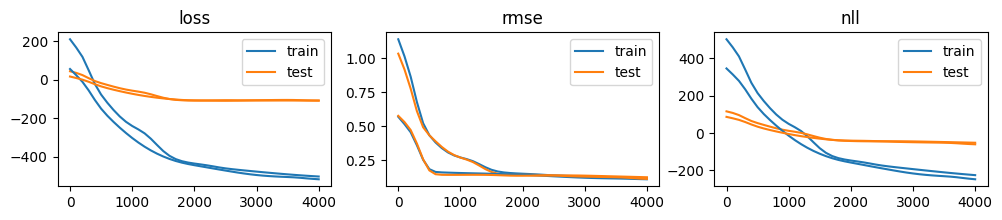

In [5]:
figure_training = plot_training_losses(point_estimates)
figure_training

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 210.94it/s]


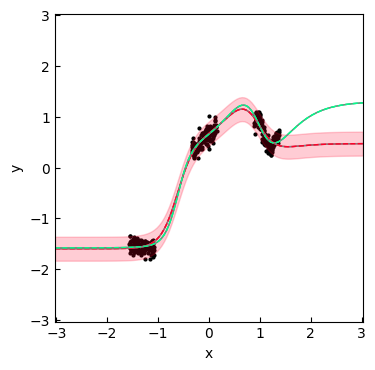

In [6]:
de_parameters = [element.transformation_parameters_vector for element in point_estimates]

figure = visualization.RegressionFigure(
    settings=settings.SettingsRegressionFigure(
        settings_plot=settings.SettingsPlot(
            alpha=1.0,
            aleatoric=True
        )
    ),
)
figure_regression = figure.plot(
    dataset=dataset,
    transformation=model_transformation.apply_from_vector,
    parameters_list=de_parameters,
    std=jnp.exp(point_estimates[0].parameters["log_std"]))
figure_regression

In [7]:
print(jnp.exp(point_estimates[0].parameters["log_std"]))

0.12032014


# save history and parameters, give a identifying name

In [8]:
print(point_estimates[0].parameters_serializable)

{'transformation': [[2.569070816040039, -1.091586709022522, -1.8188560009002686, -2.7115492820739746, 1.5589206218719482, -2.9477057456970215, -0.5613703727722168, 1.1085773706436157, 1.0856351852416992, -1.056591510772705]], 'log_std': -2.1175992488861084}


In [9]:
results_name = f"de_parameters_{network_size}_{dataset_name}.json"
d = {}
for i, element in enumerate(point_estimates):
    d[i] = {
        "history":element.history,
        "parameters": element.parameters_serializable
    }

with open(os.path.join(global_settings.PATH_PAPER_RESULTS, results_name), 'w') as f:
    json.dump(d, f)
print(os.path.join(global_settings.PATH_PAPER_RESULTS, results_name))

/home/gw/data/experiments/paper/results/de_parameters_small_izmailov.json


# laplace approximation

In [10]:
import torch
import laplace
from torch.utils.data import Dataset, DataLoader
import numpy as np
from utils.conversion import flax_parameters_dict_to_torch_parameters_vector, torch_parameters_vector_to_flax_parameters_dict, torch_parameters_vector_to_flax_parameters_vector, torch_to_flax_permutation
from numpyro import distributions

In [11]:
point_estimate_la = point_estimates[0].parameters["transformation"]
point_estimate_la_vector = point_estimates[0].transformation_parameters_vector

In [12]:
if network_size == "small":
    model_transformation_la = torch.nn.Sequential(
        torch.nn.Linear(1, 3),
        torch.nn.Tanh(),
        torch.nn.Linear(3, 1)
    )
elif network_size == "big":
    model_transformation_la = torch.nn.Sequential(
        torch.nn.Linear(1, 16),
        torch.nn.Tanh(),
        torch.nn.Linear(16, 16),
        torch.nn.Tanh(),
        torch.nn.Linear(16, 16),
        torch.nn.Tanh(),
        torch.nn.Linear(16, 1)
    )

class ConditionalDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self._data = data
    
    def __getitem__(self, index):
        sample = self._data[index]
        conditional = sample[..., :1]
        dependent = sample[..., 1:]
        return conditional, dependent
    
    def __len__(self):
        return len(self._data)

torch_dataset = ConditionalDataset(data=torch.from_numpy(np.array(dataset.data)))
train_loader = DataLoader(torch_dataset, batch_size=len(torch_dataset))

In [13]:
posterior_mean = point_estimate_la_vector
torch_parameters = flax_parameters_dict_to_torch_parameters_vector(point_estimate_la)
torch.nn.utils.vector_to_parameters(torch_parameters, model_transformation_la.parameters())

# initial la fit
hessian="full"
model = model_transformation_la
la = laplace.Laplace(
    model=model,
    sigma_noise=0.3,
    likelihood="regression",
    subset_of_weights="all",
    hessian_structure=hessian,
    prior_precision=1.0
)
la.fit(train_loader)

# optimize sigma noise and prior precision
log_prior, log_sigma = torch.zeros(1, requires_grad=True), torch.zeros(1, requires_grad=True)
print(log_prior.exp(), log_sigma.exp())
hyper_optimizer = torch.optim.Adam([log_sigma], lr=1e-2)
for i in range(int(1e3)):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()
    if i % 100 == 0:
        with torch.no_grad():
            print(log_prior.exp(), log_sigma.exp())
print(log_prior.exp(), log_sigma.exp())

permutation_indices = torch_to_flax_permutation(point_estimate_la)

if hessian == "diag":
    posterior_precision = jnp.array(np.diag(la.posterior_precision.detach().numpy()))[permutation_indices][:, permutation_indices]
else:
    posterior_precision = jnp.array(la.posterior_precision.detach().numpy())[permutation_indices][:, permutation_indices]

posterior = distributions.MultivariateNormal(posterior_mean, precision_matrix=posterior_precision)
la_samples_package = jnp.array(la.sample(n_samples=1024).detach().numpy())
la_samples_custom_0 = posterior.sample(rng_key, (1274, ))
la_samples_package_flax = la_samples_package[:, permutation_indices]

tensor([1.], grad_fn=<ExpBackward0>) tensor([1.], grad_fn=<ExpBackward0>)
tensor([1.]) tensor([0.9900])
tensor([1.]) tensor([0.3694])
tensor([1.]) tensor([0.1629])
tensor([1.]) tensor([0.1236])
tensor([1.]) tensor([0.1224])
tensor([1.]) tensor([0.1224])
tensor([1.]) tensor([0.1224])
tensor([1.]) tensor([0.1224])
tensor([1.]) tensor([0.1224])
tensor([1.]) tensor([0.1224])
tensor([1.], grad_fn=<ExpBackward0>) tensor([0.1224], grad_fn=<ExpBackward0>)


100%|███████████████████████████████████████████| 1274/1274 [00:03<00:00, 329.77it/s]


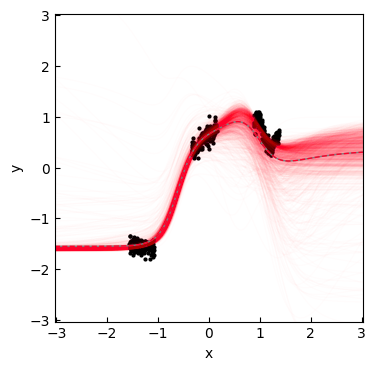

In [18]:
figure = visualization.RegressionFigure(
    settings=settings.SettingsRegressionFigure(
        settings_plot=settings.SettingsPlot(
            alpha=0.01,
            aleatoric=False
        )
    ),
)
figure_regression = figure.plot(
    dataset=dataset,
    transformation=model_transformation.apply_from_vector,
    parameters_list=[la_samples_custom_0.squeeze()],
    std=jnp.exp(point_estimates[0].parameters["log_std"]))
figure_regression

In [16]:
results_name = f"la_parameters_{network_size}_{dataset_name}.json"
d = {}
for i, element in enumerate(la_samples_custom_0):
    d[i] = {
        "parameters": np.array(element).tolist()
    }

with open(os.path.join(global_settings.PATH_PAPER_RESULTS, results_name), 'w') as f:
    json.dump(d, f)
print(os.path.join(global_settings.PATH_PAPER_RESULTS, results_name))

/home/gw/data/experiments/paper/results/la_parameters_small_izmailov.json


In [17]:
with open(os.path.join(global_settings.PATH_PAPER_RESULTS, results_name), 'r') as f:
    dd = json.load(f)
print(dd)

{'0': {'parameters': [[3.067228078842163, -1.078908920288086, -1.6659810543060303, -3.065458059310913, 1.1966632604599, -2.838545799255371, -0.43547505140304565, 0.9571318626403809, 1.0437240600585938, -1.070048451423645]]}, '1': {'parameters': [[2.879568099975586, -0.7183968424797058, -1.7820817232131958, -2.699481964111328, 0.699285626411438, -2.882427930831909, -0.42937612533569336, 0.8896616697311401, 1.070967674255371, -0.9948344230651855]]}, '2': {'parameters': [[1.9805858135223389, -0.9531240463256836, -2.040526866912842, -1.7644400596618652, 0.41492271423339844, -2.9614415168762207, -0.3471653461456299, 1.9358444213867188, 2.296644687652588, -0.918685257434845]]}, '3': {'parameters': [[2.109236001968384, -1.4439915418624878, -1.5455589294433594, -2.317171096801758, 1.804923176765442, -2.557734727859497, -0.5895872712135315, 1.5958589315414429, 1.4872242212295532, -1.126193881034851]]}, '4': {'parameters': [[0.9995077848434448, -2.211923122406006, -1.544805884361267, -1.78798079